### BABILong: evaluation example

Download BABILong repository.


In [1]:
import sys, site, ipykernel
print("Python:", sys.version)
print("Executable:", sys.executable)
print("Prefix:", sys.prefix)
print("Site-packages:", site.getsitepackages())


Python: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
Executable: D:\Users\Louis\PycharmProjects\Master_thesis\Babilong_Benchmark\.venv\Scripts\python.exe
Prefix: D:\Users\Louis\PycharmProjects\Master_thesis\Babilong_Benchmark\.venv
Site-packages: ['D:\\Users\\Louis\\PycharmProjects\\Master_thesis\\Babilong_Benchmark\\.venv', 'D:\\Users\\Louis\\PycharmProjects\\Master_thesis\\Babilong_Benchmark\\.venv\\Lib\\site-packages']


In [2]:
import sys, pathlib
print(pathlib.Path(sys.executable).resolve())

D:\Users\Louis\PycharmProjects\Master_thesis\Babilong_Benchmark\.venv\Scripts\python.exe


In [11]:
pip install -U flash-linear-attention transformers accelerate bitsandbytes


SyntaxError: invalid syntax (353553833.py, line 1)

In [2]:
pip install datasets transformers flash_attention accelerate

  Obtaining dependency information for flash_attention from https://files.pythonhosted.org/packages/7c/62/a3ffe7a541645e72298f055ec894bc5b9d890ec7cacbf068c7734e2c0998/flash_attention-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/77/85/85951bc0f9843e2c10baaa1b6657227056095de08f4d1eea7d8b423a6832/accelerate-1.11.0-py3-none-any.whl.metadata
Using cached flash_attention-1.0.0-py3-none-any.whl (31 kB)
Using cached accelerate-1.11.0-py3-none-any.whl (375 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!git clone https://github.com/booydar/babilong source

Cloning into 'source'...


In [3]:
import torch
import datasets
from transformers import AutoTokenizer, AutoModelForCausalLM

from tqdm.auto import tqdm
import pandas as pd
import json

from pathlib import Path

from source.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from source.babilong.babilong_utils import compare_answers

Let's check how BABILong data looks like:

In [4]:
# take split with 0k tokens length (no background texts from PG-19), 100 samples per task and per length
# use "RMT-team/babilong-1k" for 1000 samples per task per length
data_0k = datasets.load_dataset("RMT-team/babilong", '0k')
print(data_0k)

DatasetDict({
    qa1: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa2: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa3: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa4: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa5: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa6: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa7: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa8: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa9: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
    })
    qa10: Dataset({
        features: ['target', 'input', 'question'],
        num_rows: 100
  

In [5]:
# the first sample from qa1 with no background texts
for k in data_0k['qa1'][0]:
    print(f"{k}: {data_0k['qa1'][0][k]}")

target: bathroom
input: John travelled to the hallway. Mary journeyed to the bathroom. Daniel went back to the bathroom. John moved to the bedroom.
question: Where is Mary? 


In [6]:
# data split with 1k tokens
data_1k = datasets.load_dataset("RMT-team/babilong", '1k')
# the first sample from qa1 with no background texts
for k in data_1k['qa1'][0]:
    print(f"{k}: {data_1k['qa1'][0][k]}")

target: bathroom
input: According to the lawyers’ conception, whatever might be the
powers of Parliament when it actually came together, however much the
King might be bound to act by its advice, consent, and authority, the
Parliament itself did nevertheless derive its being from the authority
of the King. Parliament was summoned by the King’s writ. The King
might indeed be bound to issue the writs for its summons; still it was
from the King’s writ that the Parliament actually derived its being
and its powers. By another legal assumption, the force of the King’s
writ was held to last only during the lifetime of the King who issued
it. It followed therefore that Parliament, summoned by the King’s
writ and deriving its authority from the King’s writ, was dissolved
_ipso facto_ by the death of the King who summoned it. Once admit the
assumptions from which this reasoning starts, and the reasoning itself
is perfect. Let us see how
this mass of legal subtlety would have looked in the eyes o

Let's prepare sample with prompts, instructions and in-context examples:

In [5]:
from source.babilong.prompts import DEFAULT_TEMPLATE, DEFAULT_PROMPTS, get_formatted_input

task = 'qa1'
# use instruction, in-context examples, and instruction after examples
prompt_cfg = {
    'instruction': DEFAULT_PROMPTS[task]['instruction'],
    'examples': DEFAULT_PROMPTS[task]['examples'],
    'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
    'template': DEFAULT_TEMPLATE,
    }

print(f'default template: {DEFAULT_TEMPLATE}')

default template: {instruction}

{examples}

{post_prompt}

<context>
{context}
</context>

Question: {question}


In [2]:
DEFAULT_PROMPTS[task]['post_prompt']

'Always return your answer in the following format: The most recent location of ’person’ is ’location’. Do not write anything else after that.'

So, this is how input to the model is formed. You can use other templates or instructions. We provide current configuration as an example.

In [52]:
sample = data_0k[task][0]

print(get_formatted_input(sample['input'], sample['question'],
                    prompt_cfg['examples'], prompt_cfg['instruction'],
                    prompt_cfg['post_prompt'], template=DEFAULT_TEMPLATE))

I will give you context with the facts about positions of different persons hidden in some random text and a question. You need to answer the question based only on the information from the facts. If a person was in different locations, use the latest location to answer the question.

<example>
Charlie went to the hallway. Judith come back to the kitchen. Charlie travelled to balcony. Where is Charlie?
Answer: The most recent location of Charlie is balcony.
</example>

<example>
Alan moved to the garage. Charlie went to the beach. Alan went to the shop. Rouse travelled to balcony. Where is Alan?
Answer: The most recent location of Alan is shop.
</example>

Always return your answer in the following format: The most recent location of ’person’ is ’location’. Do not write anything else after that.

<context>
John travelled to the hallway. Mary journeyed to the bathroom. Daniel went back to the bathroom. John moved to the bedroom.
</context>

Question: Where is Mary?


In [6]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("Model dtype:", next(model.parameters()).dtype)
print("Model device:", next(model.parameters()).device)


CUDA available: True
GPU: NVIDIA GeForce RTX 3080


NameError: name 'model' is not defined

Let's run Phi3-mini on tasks from BABILong, save prediction, and plot results.

In [15]:
from huggingface_hub import snapshot_download
local_dir = snapshot_download(repo_id="fla-hub/delta_net-1.3B-100B")
local_dir

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.73G [00:00<?, ?B/s]

'C:\\Users\\Louis\\.cache\\huggingface\\hub\\models--fla-hub--delta_net-1.3B-100B\\snapshots\\b4dcbbafd4fde802717bdec3008d4aba9cb3a1f8'

In [17]:
import os, json, pprint, pathlib
print("DIR:", pathlib.Path(local_dir))
print("FILES:", os.listdir(local_dir))
cfg = json.load(open(os.path.join(local_dir, "config.json")))
print("model_type:", cfg.get("model_type"))
print("architectures:", cfg.get("architectures"))
print("has auto_map:", "auto_map" in cfg)
pprint.pp(cfg.get("auto_map"))

DIR: C:\Users\Louis\.cache\huggingface\hub\models--fla-hub--delta_net-1.3B-100B\snapshots\b4dcbbafd4fde802717bdec3008d4aba9cb3a1f8
FILES: ['.gitattributes', 'config.json', 'generation_config.json', 'model.safetensors', 'README.md', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer.model', 'tokenizer_config.json']
model_type: delta_net
architectures: ['DeltaNetForCausalLM']
has auto_map: False
None


In [18]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="fla-hub/delta_net-1.3B-100B")

ValueError: The checkpoint you are trying to load has model type `delta_net` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.

You can update Transformers with the command `pip install --upgrade transformers`. If this does not work, and the checkpoint is very new, then there may not be a release version that supports this model yet. In this case, you can get the most up-to-date code by installing Transformers from source with the command `pip install git+https://github.com/huggingface/transformers.git`

In [24]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

12.4
True


In [27]:
import torch
print("CUDA:", torch.cuda.is_available(), "|", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

CUDA: True | NVIDIA GeForce RTX 3080


In [26]:
import fla
from fla.models.delta_net import DeltaNetForCausalLM
print("fla OK")

Detected Windows operating system. Triton does not have an official Windows release, thus FLA will not be adapted for Windows, and any potential errors will not be fixed. Please consider using a Linux environment for compatibility.


fla OK


In [7]:
results_folder = './babilong_evals'
model_name = "fla-hub/delta_net-1.3B-100B"
dtype = torch.bfloat16
device = 'cuda:0'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True,
                                             device_map=device, torch_dtype=dtype,)
                                            #  attn_implementation='flash_attention_2') # uncomment to run with flash attention 2
model = model.eval()

ValueError: The checkpoint you are trying to load has model type `delta_net` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.

You can update Transformers with the command `pip install --upgrade transformers`. If this does not work, and the checkpoint is very new, then there may not be a release version that supports this model yet. In this case, you can get the most up-to-date code by installing Transformers from source with the command `pip install git+https://github.com/huggingface/transformers.git`

In [49]:
from fla.models.delta_net import DeltaNetForCausalLM
from transformers import AutoTokenizer

results_folder = './babilong_evals'
model_name = "fla-hub/delta_net-1.3B-100B"
dtype = torch.float16   # safer than bfloat16 on Windows/consumer GPUs
device = 'cuda:0'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = DeltaNetForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map=device,
    torch_dtype=dtype,
).eval()

In [48]:
# specify tasks and lengths
tasks = ['qa1'] #[,'qa3', 'qa4', 'qa5']
split_names = ['1k'] #, '2k', '4k', '8k', '16k', '32k']

In [40]:
generate_kwargs = {
      'max_new_tokens': 20,
      'max_length': None,
      'num_beams': 1,
      'do_sample': False,
      'temperature': None,
      'top_p': None,
      'top_k': None,
      'pad_token_id': tokenizer.pad_token_id
  }

if generate_kwargs['pad_token_id'] is None:
    generate_kwargs['pad_token_id'] = tokenizer.eos_token_id

use_chat_template = False
use_instruction = True
use_examples = True
use_post_prompt = True

In [41]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.model_max_length = 2_000_000_000  # effectively “no cap” on HF side

In [55]:
#understand how the dataset works
data = datasets.load_dataset('RMT-team/babilong', '1k')

In [59]:
data_qa1 = data['qa1']

In [61]:
# Print the keys (splits) in the DatasetDict
print(type(data_qa1))

<class 'datasets.arrow_dataset.Dataset'>


In [62]:
# Check the type of data_qa1
print("Type of data_qa1:", type(data_qa1))

# Print the number of samples in data_qa1
print("Number of samples in data_qa1:", len(data_qa1))

# Print the first few keys and their corresponding values
print("First sample keys and values:")
for key, value in data_qa1[0].items():
    print(f"{key}: {value}")

Type of data_qa1: <class 'datasets.arrow_dataset.Dataset'>
Number of samples in data_qa1: 100
First sample keys and values:
target: bathroom
input: According to the lawyers’ conception, whatever might be the
powers of Parliament when it actually came together, however much the
King might be bound to act by its advice, consent, and authority, the
Parliament itself did nevertheless derive its being from the authority
of the King. Parliament was summoned by the King’s writ. The King
might indeed be bound to issue the writs for its summons; still it was
from the King’s writ that the Parliament actually derived its being
and its powers. By another legal assumption, the force of the King’s
writ was held to last only during the lifetime of the King who issued
it. It followed therefore that Parliament, summoned by the King’s
writ and deriving its authority from the King’s writ, was dissolved
_ipso facto_ by the death of the King who summoned it. Once admit the
assumptions from which this reaso

In [76]:
print(split_names)

['1k']


In [77]:
for task in tqdm(tasks, desc='tasks'):
    # configure the prompt
    prompt_cfg = {
        'instruction': DEFAULT_PROMPTS[task]['instruction'] if use_instruction else '',
        'examples': DEFAULT_PROMPTS[task]['examples'] if use_examples else '',
        'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'] if use_post_prompt else '',
        'template': DEFAULT_TEMPLATE,
        'chat_template': use_chat_template,
    }
    prompt_name = [f'{k}_yes' if prompt_cfg[k] else f'{k}_no' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)

    for split_name in tqdm(split_names, desc='lengths'):
        print("NEW SPLIT NAME")
        # load dataset
        data = datasets.load_dataset('RMT-team/babilong', split_name)
        task_data = data[task]

        # Prepare files with predictions, prompt, and generation configurations
        outfile = Path(f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': [], 'question': []})
        i = 0
        for sample in tqdm(task_data, desc=f'task: {task} length: {split_name}'):
            print(i)
            i += 1
            print(len(tqdm(task_data, desc=f'task: {task} length: {split_name}')))
            target = sample['target']
            context = sample['input']
            question = sample['question']

            # format input text
            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=prompt_cfg['template'])

            if use_chat_template:
                input_text = [{'role': 'user', 'content': input_text}]
                model_inputs = tokenizer.apply_chat_template(input_text, add_generation_prompt=True,
                                                             return_tensors='pt').to(model.device)
                model_inputs = {'input_ids': model_inputs}
            else:
                model_inputs = tokenizer(input_text, return_tensors='pt',
                                         add_special_tokens=True).to(model.device)

            sample_length = model_inputs['input_ids'].shape[1]
            with torch.no_grad():
                output = model.generate(**model_inputs, **generate_kwargs)

            output = output[0][sample_length:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output, question]
            # write results to csv file
            df.to_csv(outfile)

        # Print the location of the output file
        print(f"Output file saved at: {outfile.resolve()}")

tasks:   0%|          | 0/1 [00:00<?, ?it/s]

lengths:   0%|          | 0/1 [00:00<?, ?it/s]

NEW SPLIT NAME


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

0


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
1


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
2


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
3


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
4


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
5


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
6


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
7


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
8


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
9


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
10


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
11


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
12


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
13


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
14


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
15


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
16


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
17


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
18


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
19


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
20


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
21


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
22


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
23


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
24


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
25


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
26


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
27


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
28


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
29


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
30


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
31


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
32


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
33


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
34


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
35


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
36


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
37


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
38


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
39


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
40


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
41


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
42


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
43


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
44


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
45


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
46


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
47


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
48


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
49


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
50


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
51


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
52


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
53


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
54


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
55


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
56


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
57


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
58


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
59


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
60


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
61


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
62


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
63


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
64


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
65


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
66


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
67


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
68


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
69


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
70


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
71


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
72


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
73


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
74


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
75


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
76


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
77


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
78


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
79


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
80


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
81


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
82


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
83


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
84


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
85


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
86


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
87


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
88


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
89


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
90


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
91


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
92


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
93


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
94


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
95


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
96


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
97


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
98


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
99


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

100
Output file saved at: D:\Users\Louis\PycharmProjects\Master_thesis\Babilong_Benchmark\notebooks\babilong_evals\fla-hub\delta_net-1.3B-100B\qa1_1k_instruction_yes_examples_yes_post_prompt_yes_chat_template_no.csv


## Compute metrics and plot results

In [43]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import os

import pandas as pd
import numpy as np

from source.babilong.metrics import compare_answers, TASK_LABELS

In [44]:
import numpy as np
import matplotlib

In [71]:
import os
print(os.getcwd())

D:\Users\Louis\PycharmProjects\Master_thesis\Babilong_Benchmark\notebooks


Accuracy matrix:
[[30.]]


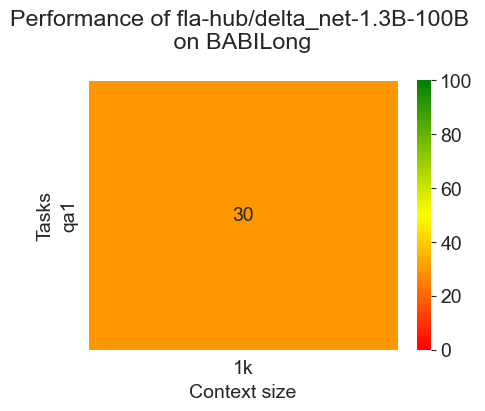

In [78]:
model_name = 'fla-hub/delta_net-1.3B-100B'
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes_chat_template_yes'

lengths = split_names
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = 'D:/Users/Louis/PycharmProjects/Master_thesis/Babilong_Benchmark/babilong_evals/fla-hub/delta_net-1.3B-100B/qa1_1k_instruction_yes_examples_yes_post_prompt_yes_chat_template_no.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue

        df = pd.read_csv(fname)

        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')

        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output'],
                                                             row['question'], TASK_LABELS[task]
                                                             ), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Print the accuracy matrix
print("Accuracy matrix:")
print(accuracy)

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

We have more examples with evaluation of various models in ./notebooks and ./scripts folders.

E.g. how to run models that are hosted on HuggingFace with default prompts `scripts/run_model_on_babilong.py`.

```bash
RESULTS_FOLDER="./babilong_evals"
DATASET_NAME="booydar/babilong-1k-samples"
MODEL_NAME="mistralai/Mistral-7B-Instruct-v0.2"
TASKS=("qa1" "qa2" "qa3" "qa4" "qa5")
LENGTHS=("0k" "1k" "2k" "4k" "8k" "16k" "32k")
USE_CHAT_TEMPLATE=true
USE_INSTRUCTION=true
USE_EXAMPLES=true
USE_POST_PROMPT=true
API_URL=""

echo running $MODEL_NAME on "${TASKS[@]}" with "${LENGTHS[@]}"

python scripts/run_model_on_babilong.py \
    --results_folder "$RESULTS_FOLDER" \
    --dataset_name "$DATASET_NAME" \
    --model_name "$MODEL_NAME" \
    --tasks "${TASKS[@]}" \
    --lengths "${LENGTHS[@]}" \
    $( [ "$USE_CHAT_TEMPLATE" == true ] && echo "--use_chat_template" ) \
    $( [ "$USE_INSTRUCTION" == true ] && echo "--use_instruction" ) \
    $( [ "$USE_EXAMPLES" == true ] && echo "--use_examples" ) \
    $( [ "$USE_POST_PROMPT" == true ] && echo "--use_post_prompt" ) \
    --api_url "$API_URL"
```

It is also possible to evaluate models that are running through API (e.g., llamacpp):
```bash
RESULTS_FOLDER="./babilong_evals"
DATASET_NAME="booydar/babilong"
MODEL_NAME="CohereForAI/c4ai-command-r-v01"
TASKS=("qa1" "qa2" "qa3" "qa4" "qa5")
LENGTHS=("64k" "128k")
USE_CHAT_TEMPLATE=true
USE_INSTRUCTION=true
USE_EXAMPLES=true
USE_POST_PROMPT=true
API_URL="http://localhost:8081/completion"

echo running $MODEL_NAME on "${TASKS[@]}" with "${LENGTHS[@]}"

python scripts/run_model_on_babilong.py \
    --results_folder "$RESULTS_FOLDER" \
    --dataset_name "$DATASET_NAME" \
    --model_name "$MODEL_NAME" \
    --tasks "${TASKS[@]}" \
    --lengths "${LENGTHS[@]}" \
    $( [ "$USE_CHAT_TEMPLATE" == true ] && echo "--use_chat_template" ) \
    $( [ "$USE_INSTRUCTION" == true ] && echo "--use_instruction" ) \
    $( [ "$USE_EXAMPLES" == true ] && echo "--use_examples" ) \
    $( [ "$USE_POST_PROMPT" == true ] && echo "--use_post_prompt" ) \
    --api_url "$API_URL"
```